In [236]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Dense
from keras.models import Model
from sklearn.manifold import TSNE
from clustering import som

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os
import numpy as np

In [36]:
model = ResNet50(weights='imagenet')

In [37]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [38]:
def predict(img):
    x = preprocess_image(img)
    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('Predicted:', decode_predictions(preds, top=3)[0])

In [53]:
path = 'data/extracted/person/'
img = '{}1523315614.881327_160669.png'.format(path)
img2 = '{}1522396712.836077_183705.png'.format(path)
img3 = '{}1522396712.829623_181743.png'.format(path)
img4 = '{}1523315864.781852_160669.png'.format(path)

predict(img)
predict(img2)
predict(img3)
predict(img4)

Predicted: [('n04591157', 'Windsor_tie', 0.36459762), ('n03595614', 'jersey', 0.13201629), ('n06359193', 'web_site', 0.08388144)]
Predicted: [('n02777292', 'balance_beam', 0.5548853), ('n03535780', 'horizontal_bar', 0.036698893), ('n03710721', 'maillot', 0.035818502)]
Predicted: [('n01795545', 'black_grouse', 0.6724429), ('n01798484', 'prairie_chicken', 0.07798819), ('n02116738', 'African_hunting_dog', 0.022047868)]
Predicted: [('n04591157', 'Windsor_tie', 0.36459762), ('n03595614', 'jersey', 0.13201629), ('n06359193', 'web_site', 0.08388144)]


In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_197 (Activation)     (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [51]:
output = model.layers[-2].output
feature_model = Model(model.input, output)

In [52]:
feature_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_197 (Activation)     (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [182]:
def extract_features(path):
    features = []
    image_paths = []
    for filename in os.listdir(path):
        if '.png' in filename:
            img_path = os.path.join(path, filename)
            x = preprocess_image(img_path)
            features.append(feature_model.predict(x)[0])
            image_paths.append(img_path)
    return (np.array(features), image_paths)

In [183]:
X, image_paths = extract_features(path)

In [184]:
np.shape(X)

(61, 2048)

In [193]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [194]:
np.shape(X_embedded)

(61, 2)

In [250]:
def plot_iamges(X_embedded, image_paths, thumbs_ratio=0.07):
    # plot the result
    vis_x = X_embedded[:, 0]
    vis_y = X_embedded[:, 1]
    
    plt.figure(figsize=(10, 10))
    xl = int((np.abs(vis_x.max() - vis_x.min())*thumbs_ratio)/2)
    yl = int((np.abs(vis_y.max() - vis_y.min())*thumbs_ratio)/2)
    
    for i, filename in enumerate(image_paths):
        img = image.load_img(image_paths[i])
        plt.imshow(img, extent=(vis_x[i]-xl, vis_x[i]+xl, vis_y[i]-yl, vis_y[i]+yl))
    plt.scatter(vis_x, vis_y, alpha=0)
    plt.show()

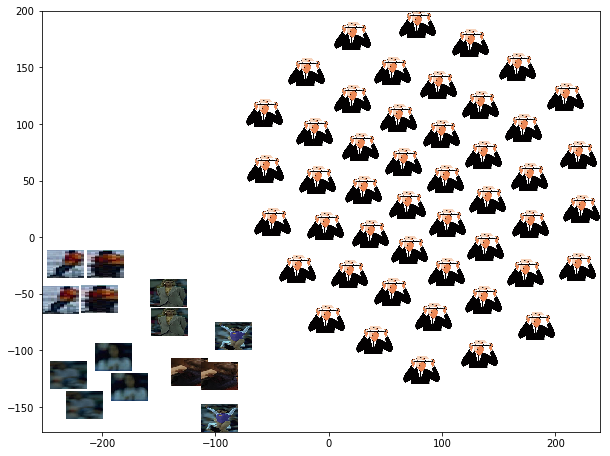

In [253]:
plot_iamges(X_embedded, image_paths)

In [219]:
som_model = som.SOM(30, 30, X.shape[1], 200)
som_model.train(X)

In [235]:
# Fit train data into SOM lattice
mapped = som_model.map_vects(X)
mappedarr = np.array(mapped)
x1 = mappedarr[:, 0] 
y1 = mappedarr[:, 1]

In [243]:
np.shape(mappedarr)

(61, 2)

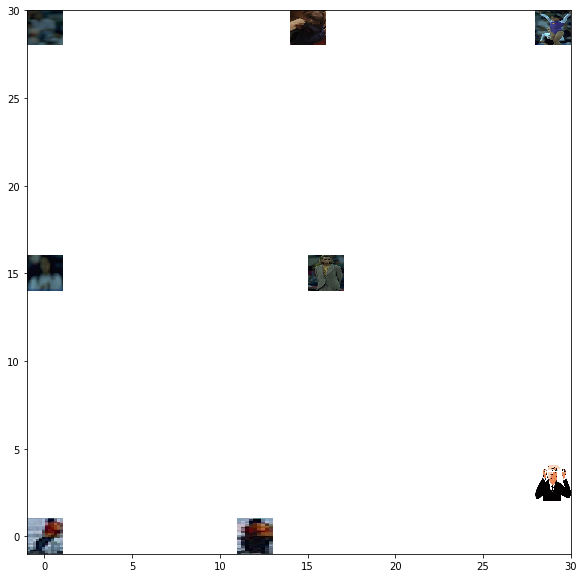

In [254]:
plot_iamges(mappedarr, image_paths, thumbs_ratio=0.1)